### Want to plot hippocampal firing rates as a function of position in block

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.io_utils as io_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats


In [2]:
PRE_INTERVAL = 500
POST_INTERVAL = 500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "FixationOnCross"
num_bins = 10


In [3]:
sessions = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(sessions)
hip_pos = positions[positions.structure_level3 == "hippocampal_formation (HF)"]

In [4]:
positions.structure_level2.unique()

array(['lateral_and_ventral_pallium (LVPal)',
       'lateral_prefrontal_cortex (lat_PFC)',
       'primary_visual_cortex (V1)', 'anterior_cingulate_gyrus (ACgG)',
       'posterior_medial_cortex (PMC)', 'orbital_frontal_cortex (OFC)',
       'unknown', 'basal_ganglia (BG)', 'inferior_temporal_cortex (ITC)',
       'motor_cortex (motor)', 'preoptic_complex (POC)', 'amygdala (Amy)',
       'extrastriate_visual_areas_2-4 (V2-V4)', 'medial_pallium (MPal)',
       'thalamus (Thal)', 'inferior_parietal_lobule (IPL)',
       'superior_parietal_lobule (SPL)',
       'floor_of_the_lateral_sulcus (floor_of_ls)',
       'medial_temporal_lobe (MTL)'], dtype=object)

In [5]:
def visualize_correlations(row):
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins)
    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    merged = pd.merge(agg, beh, on="TrialNumber")
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    ax = axs[0, 0]
    visualization_utils.plot_mean_sterrs_by_bin(merged, "FiringRate", "BlockPositionBin", ax, row.PseudoUnitID, num_bins)
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_xlabel("Relative block position")
    ax.set_ylabel("Mean firing in inter-trial")
    ax.legend()
    ax.set_title(row.structure_level2)

    ax = axs[0, 1]
    visualization_utils.plot_mean_sterrs_by_bin(merged, "FiringRate", "MaxValueBin", ax, row.PseudoUnitID, num_bins)
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_xlabel("Max Value Bin")
    ax.set_ylabel("Mean firing in inter-trial")

    ax = axs[0, 2]
    merged_filt = merged[merged.MaxValue > 0.3]
    visualization_utils.plot_bars_by_cat(merged_filt, "FiringRate", "MaxFeat", ax, order=FEATURES)
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_ylabel("Mean firing in inter-trial")
    ax.set_title("Firing by max valued feat (maxval > 0.3)")

    ax = axs[1, 0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged["BlockPosition"], merged["FiringRate"])
    ax.scatter(merged["BlockPosition"], merged["FiringRate"], alpha=0.3, color="black")
    ax.plot(merged["BlockPosition"], merged["BlockPosition"] * slope + intercept)
    ax.set_title(f"Cor w Block Position, r: {r_value:.3f}, p: {p_value:.3E}")
    ax.set_xlabel("Relative block position")
    ax.set_ylabel("Mean firing in inter-trial")

    ax = axs[1, 1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged["MaxValue"], merged["FiringRate"])
    ax.scatter(merged["MaxValue"], merged["FiringRate"], alpha=0.3, color="black")
    ax.plot(merged["MaxValue"], merged["MaxValue"] * slope + intercept)
    ax.set_title(f"Cor w Max Value: r: {r_value:.3f}, p: {p_value:.3E}")
    ax.set_xlabel("Max Value")
    ax.set_ylabel("Mean firing in inter-trial")

    ax = axs[1, 2]
    num_blocks = beh.groupby("CurrentRule").BlockNumber.nunique().reset_index()
    visualization_utils.plot_bars_by_cat(num_blocks, "BlockNumber", "CurrentRule", ax, order=FEATURES)
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_ylabel("Mean firing in inter-trial")
    ax.set_title("Number of blocks in session per rule")
    fig.tight_layout()



### Check single units:
2018092414

/src/wcst_decode/utils/behavioral_utils.py:443: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  beh = beh.groupby("BlockNumber").apply(get_block_lengths).reset_index()
/src/wcst_decode/utils/behavioral_utils.py:443: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  beh = beh.groupby("BlockNumber").app

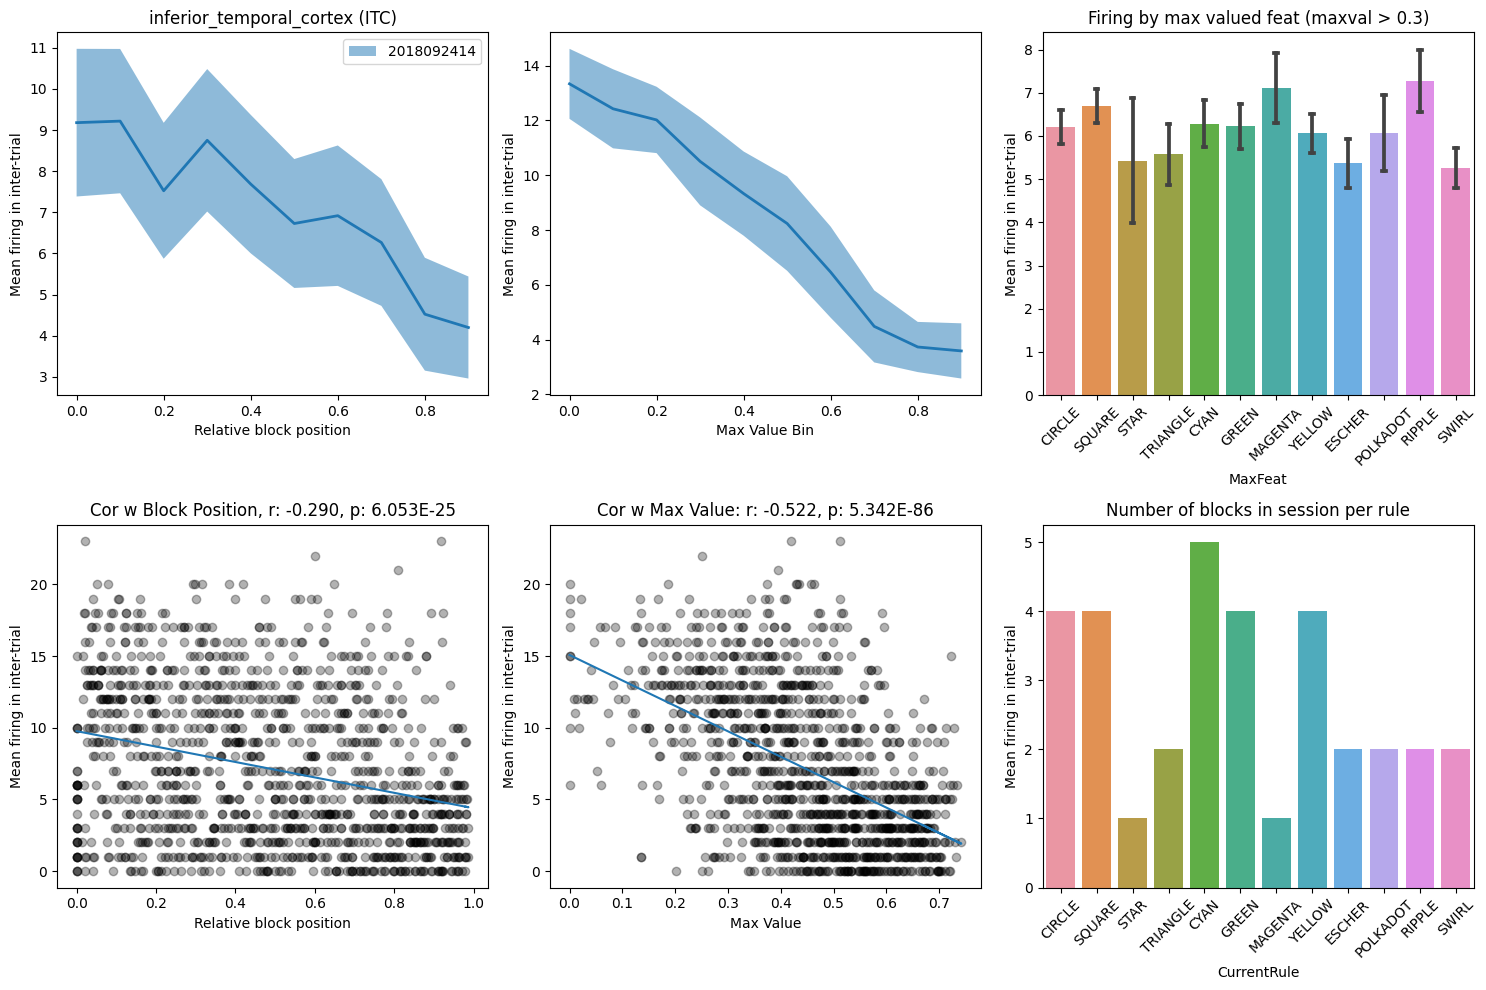

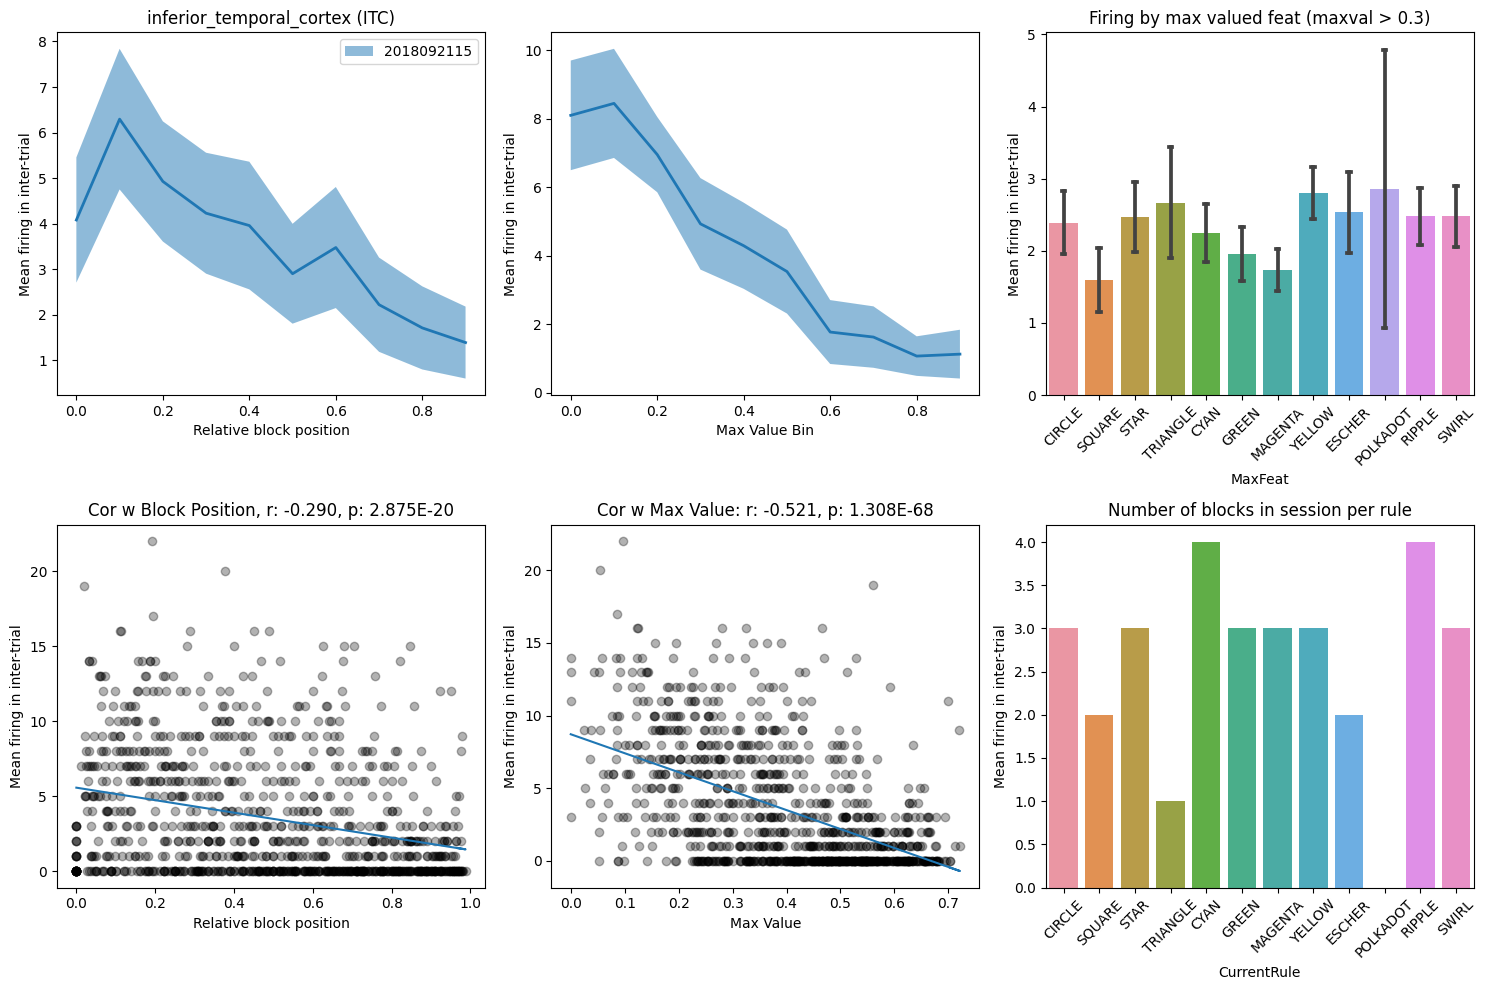

In [7]:
units = [2018092414, 2018092115]
sub_pos = positions[positions.PseudoUnitID.isin(units)]
for i, row in sub_pos.iterrows():
    visualize_correlations(row)

### Check all hippocampal units

In [ ]:
for i, row in hip_pos.iterrows():
    visualize_correlations(row)


In [ ]:
merged.MaxFeat.unique()

In [ ]:
pd.cut(merged.MaxValue, 10, labels=False)

In [ ]:
fig, ax = plt.subplots()
visualization_utils.plot_mean_sterrs_by_bin(beh, "MaxValue", "BlockPositionBin", ax, row.PseudoUnitID, 10)
ax.set_xlabel("Block Position")
ax.set_ylabel("Max Value")


### Maybe now look at OFC units? 

In [ ]:
# positions.structure_level2.unique()
ofc_pos = positions[positions.structure_level2 == "orbital_frontal_cortex (OFC)"]
for i, row in ofc_pos.iterrows():
    visualize_correlations(row)

In [ ]:
positions.structure_level2.unique()

In [ ]:
basal_pos = positions[positions.structure_level2 == "basal_ganglia (BG)"]


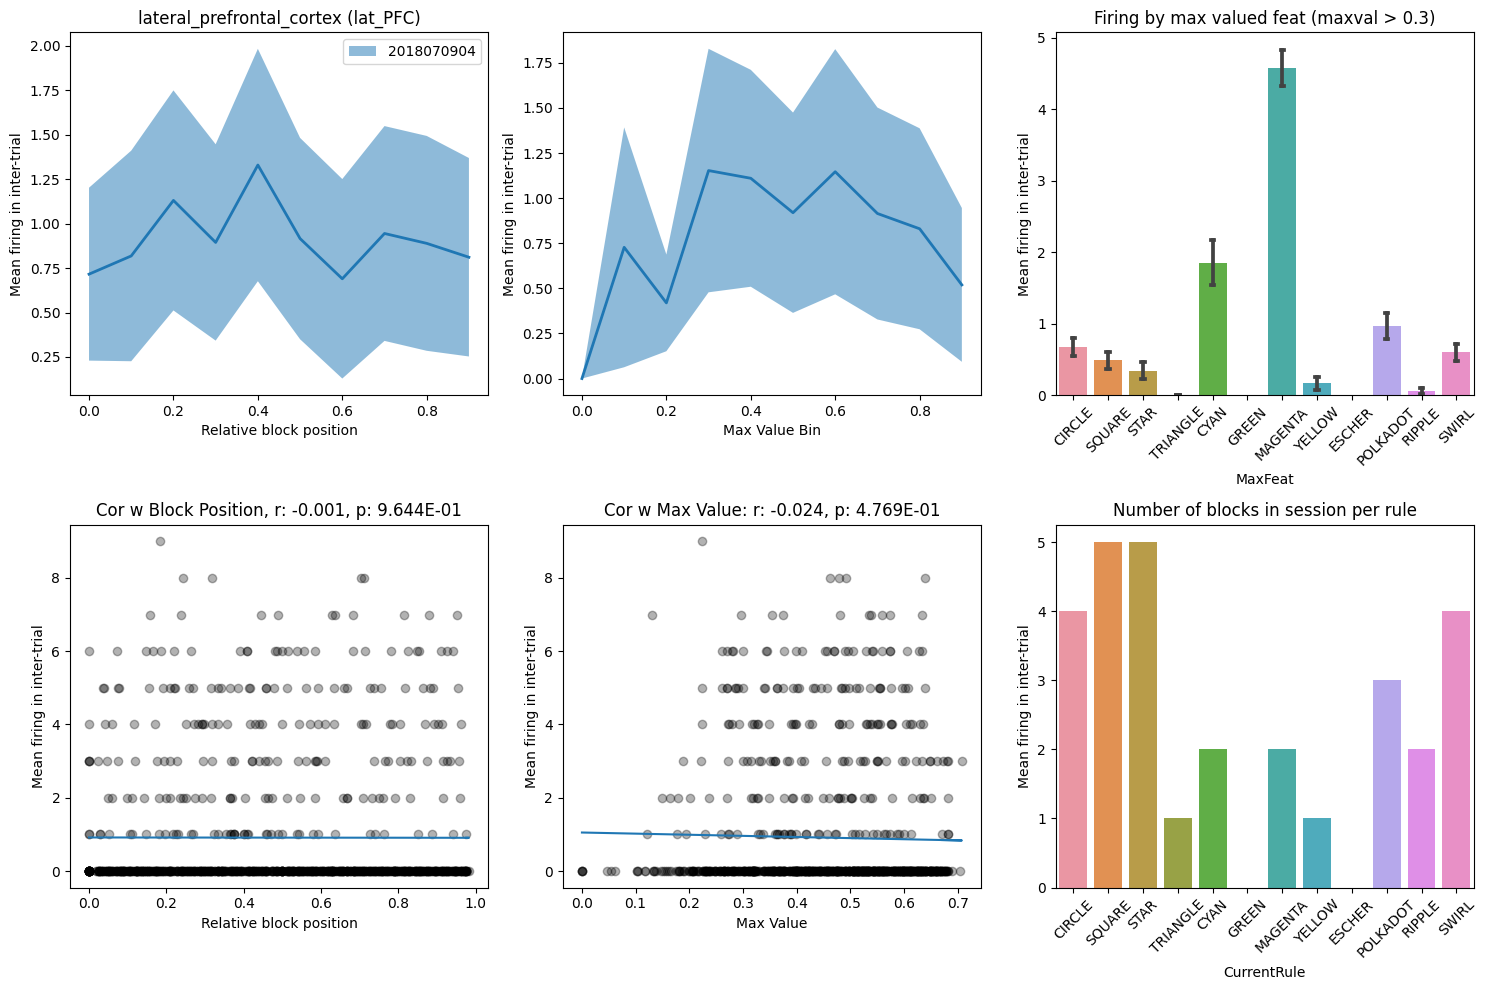

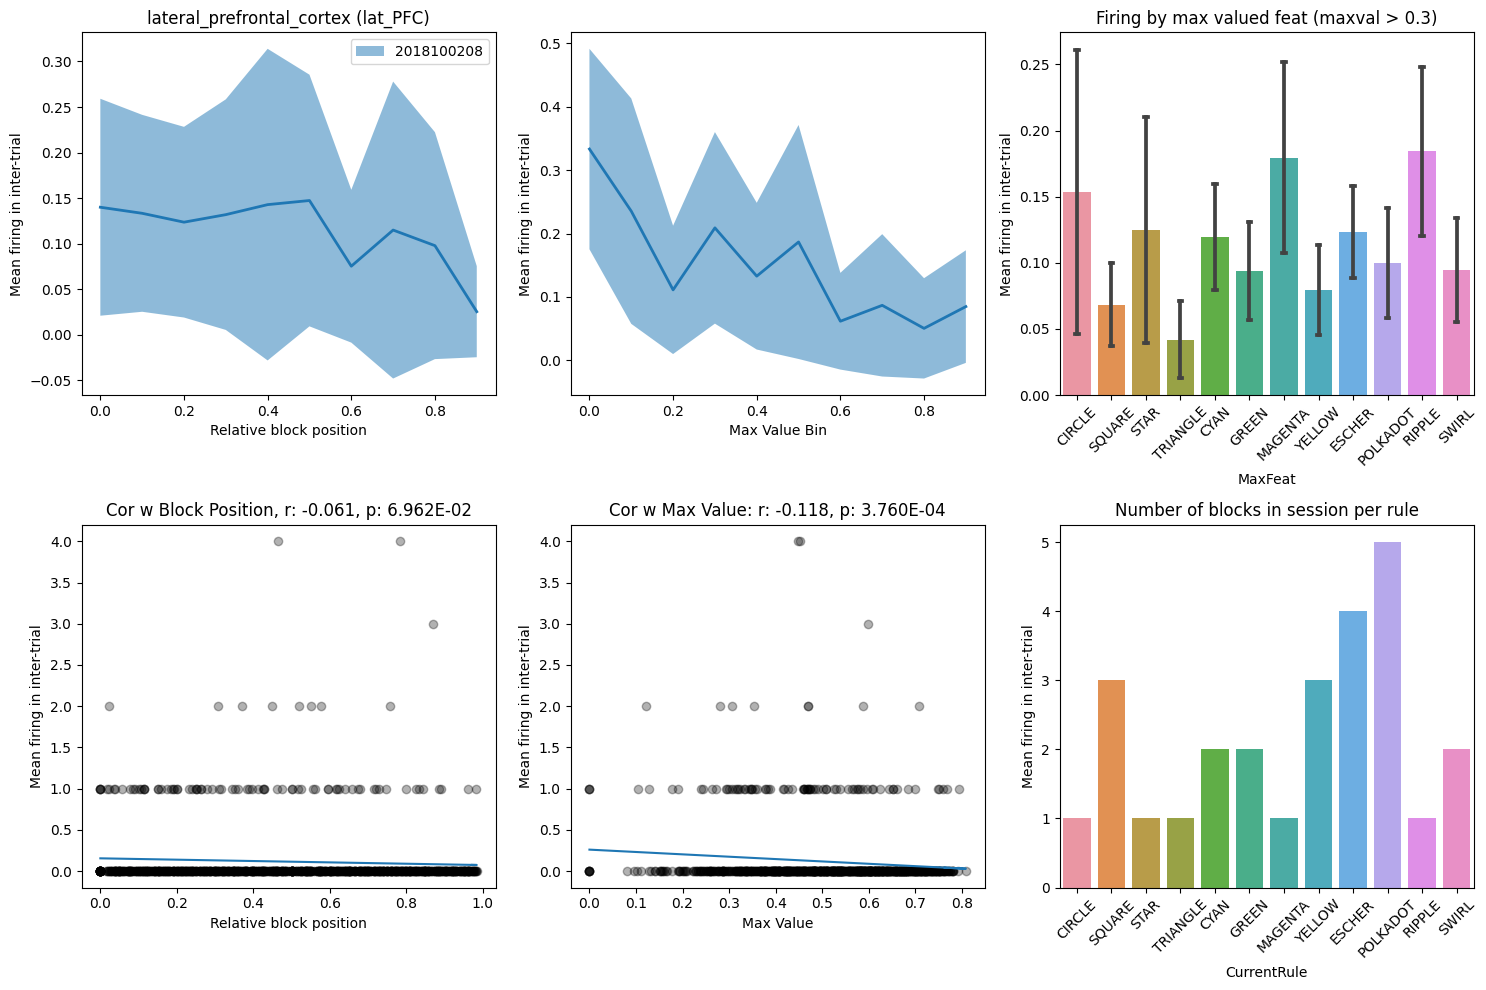

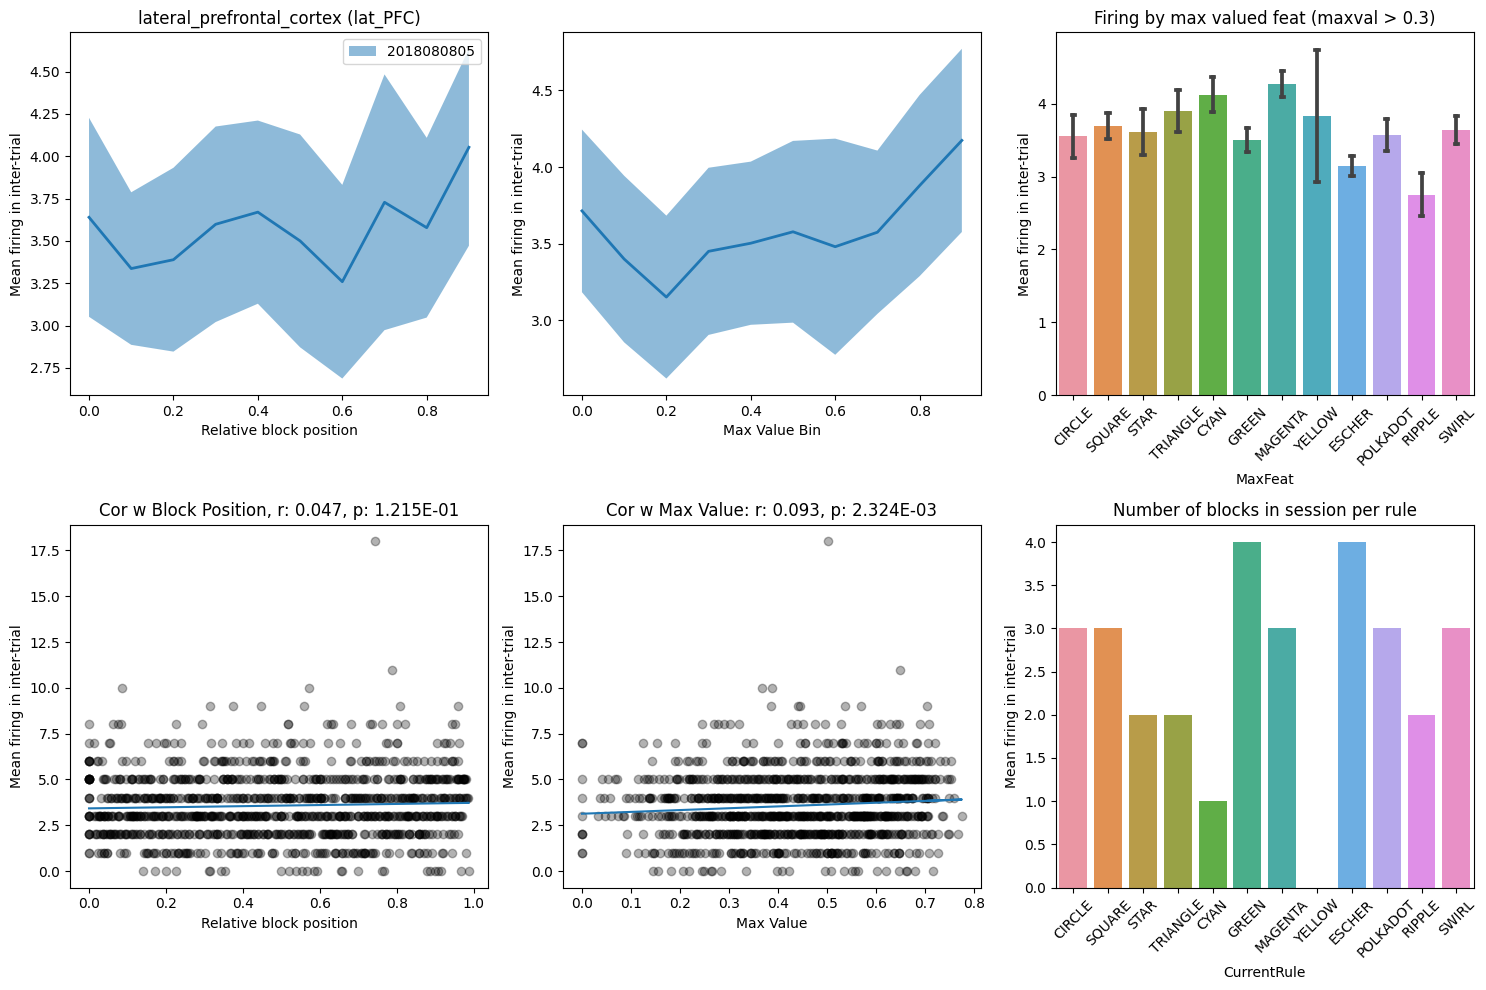

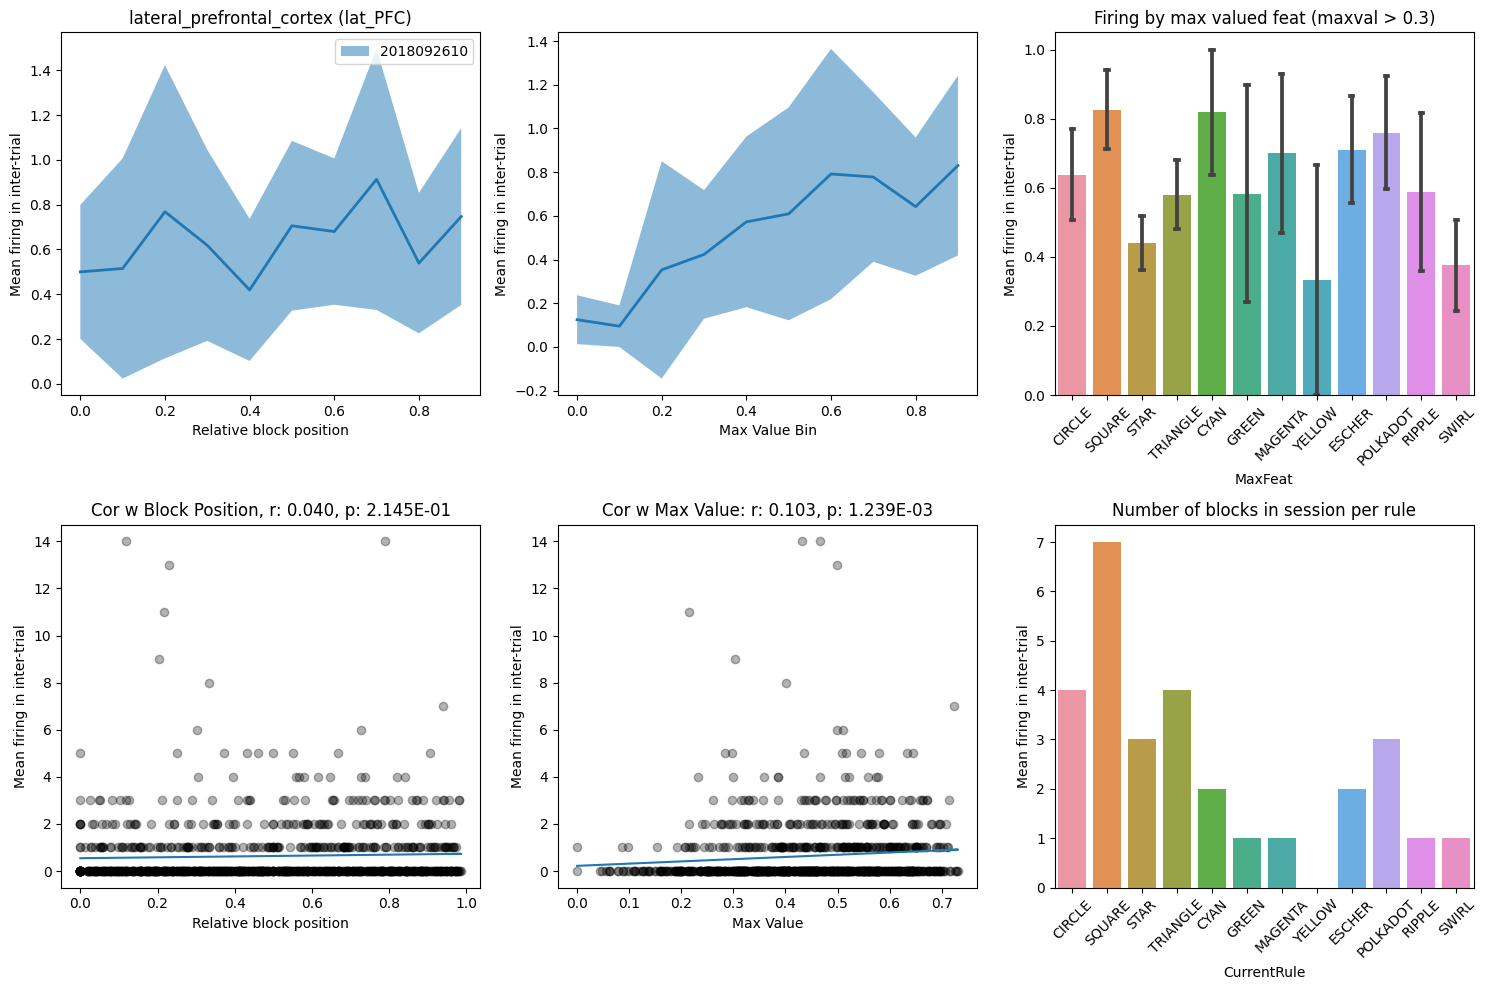

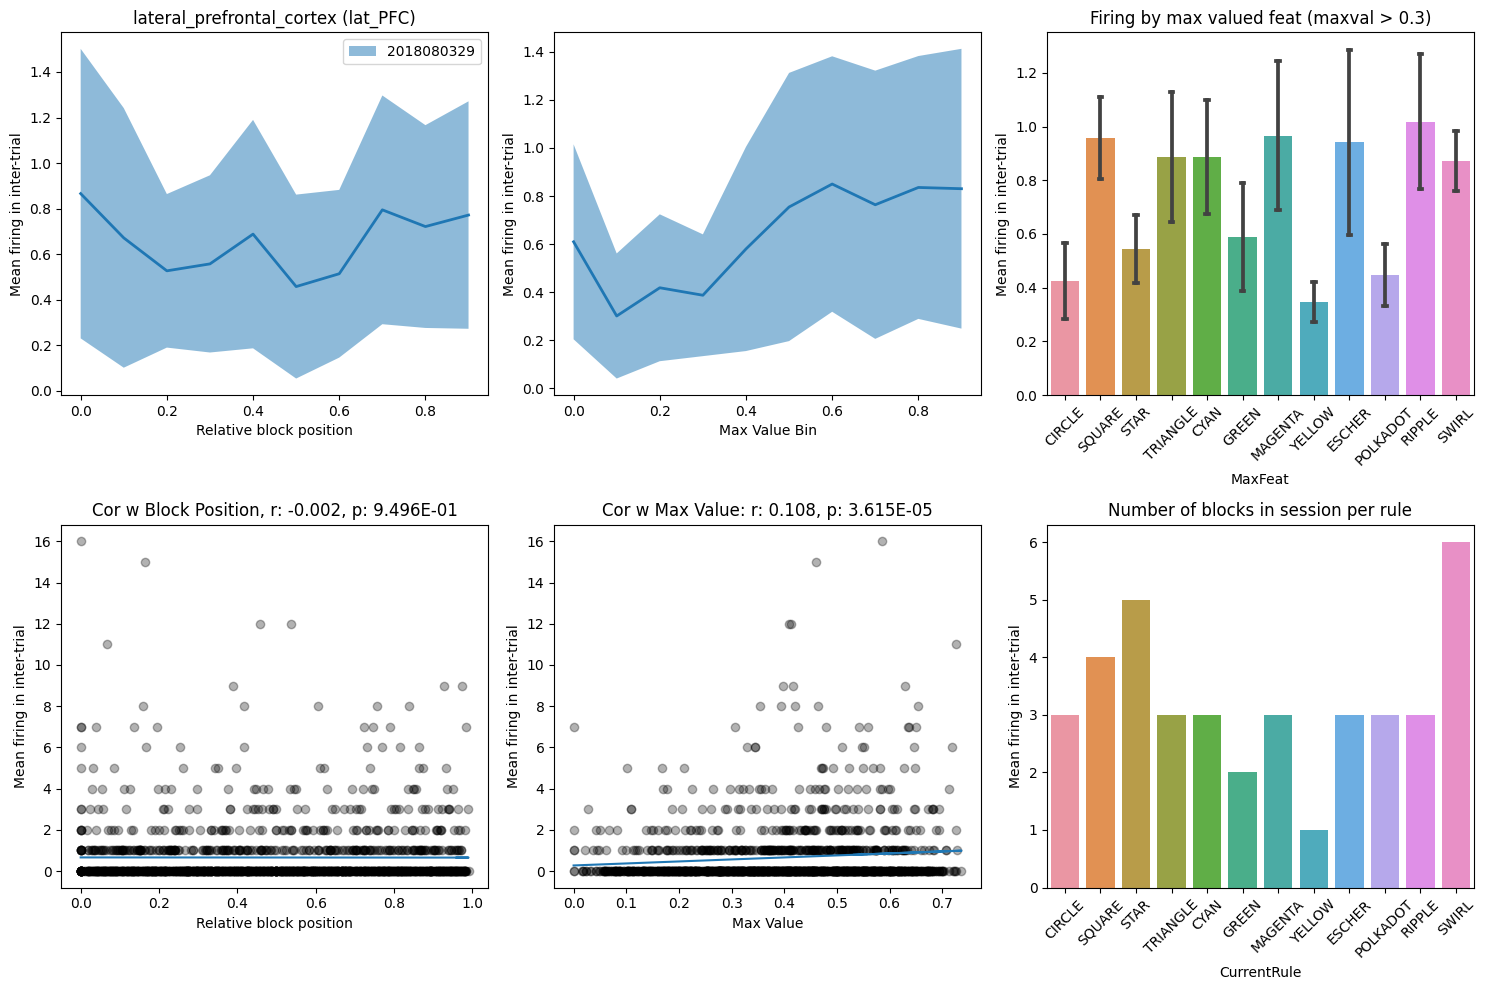

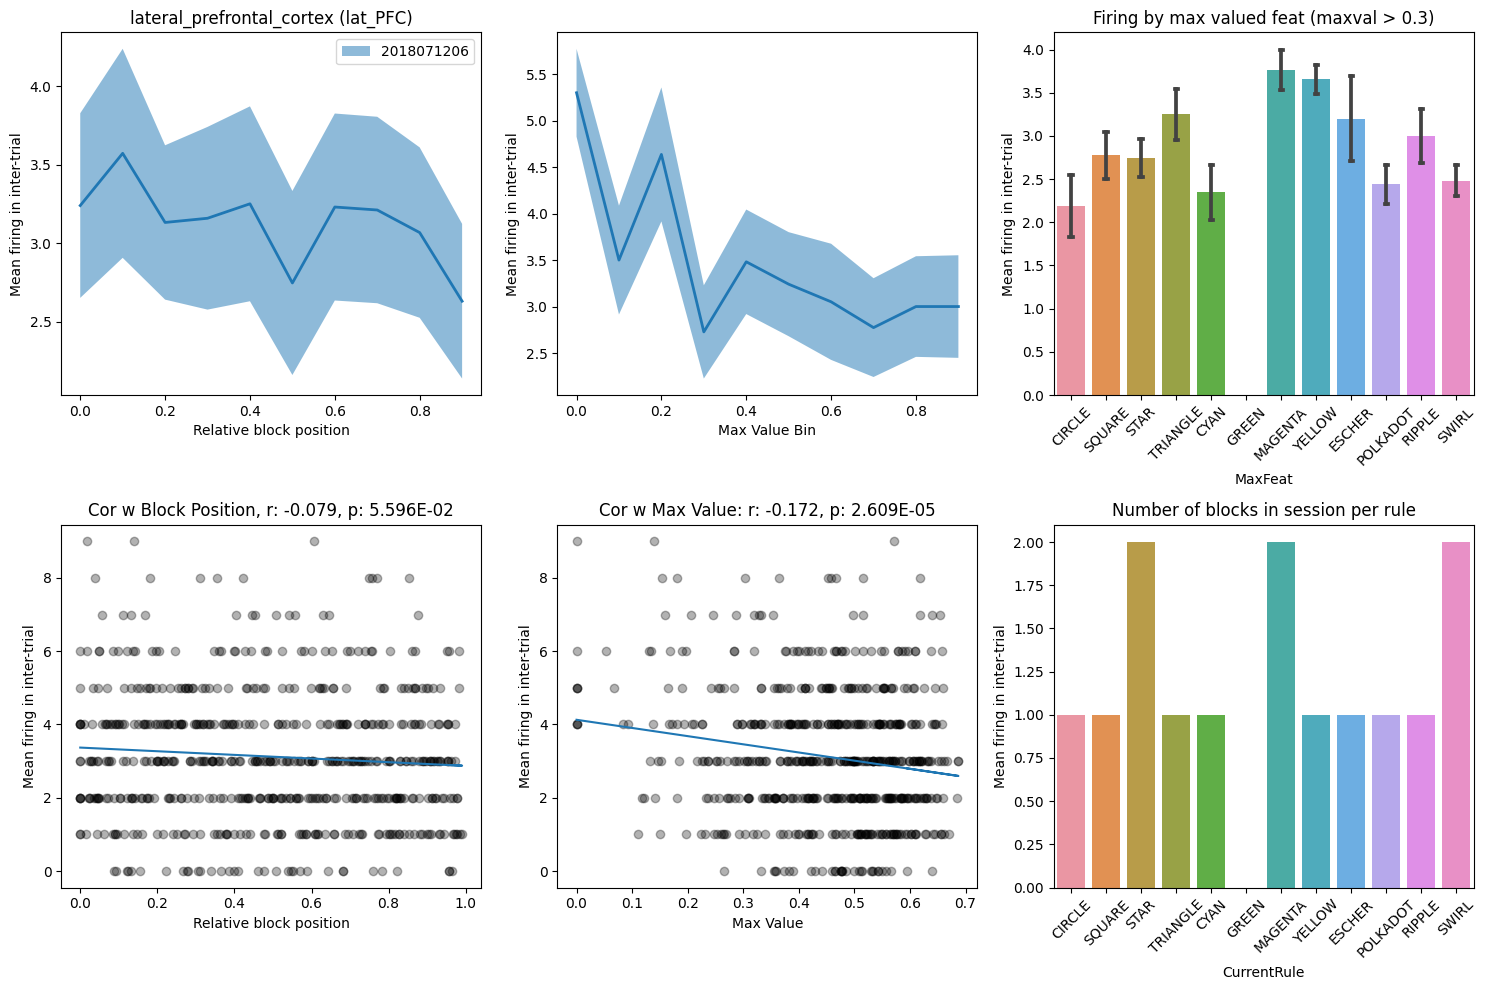

In [8]:
import warnings
warnings.filterwarnings('ignore')
lat_pfc_good_units = [2018070904, 2018100208, 2018080805, 2018092610, 2018080329, 2018071206]
lat_pfc_pos = positions[positions.PseudoUnitID.isin(lat_pfc_good_units)]
for i, row in lat_pfc_pos.iterrows():
    visualize_correlations(row)

In [1]:
it_good_units = [
    2018091815, 2018100201, 2018100211, 2018100215, 
    2018100217, 2018092620, 2018101002, 2018092104, 
    2018092107, 2018092115
]
it_pos = positions[positions.PseudoUnitID.isin(it_good_units)]
for i, row in it_pos.iterrows():
    visualize_correlations(row)

NameError: name 'positions' is not defined

In [2]:
session = row.session
fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

frs = pd.read_pickle(fr_path)
frs = frs[frs.UnitID == row.UnitID]

NameError: name 'row' is not defined

In [15]:
session = row.session

behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
beh = behavioral_utils.get_relative_block_position(beh, num_bins)
beh = behavioral_utils.get_max_feature_value(beh, num_bins)



In [20]:
beh.groupby("MaxFeat").TrialNumber.nunique()

MaxFeat
CIRCLE       16
CYAN         25
ESCHER       22
MAGENTA      87
POLKADOT     44
RIPPLE       27
SQUARE       45
STAR         72
SWIRL       106
TRIANGLE     37
YELLOW      111
Name: TrialNumber, dtype: int64

In [ ]:
agg